In [2]:
!wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AER_credit_card_data.csv

--2022-10-03 19:47:07--  https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AER_credit_card_data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 73250 (72K) [text/plain]
Saving to: ‘AER_credit_card_data.csv’

AER_credit_card_dat 100%[===================>]  71.53K  --.-KB/s    in 0.006s  

2022-10-03 19:47:08 (12.5 MB/s) - ‘AER_credit_card_data.csv’ saved [73250/73250]



In [47]:
import pandas as pd 
import numpy as np 
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

In [107]:
import matplotlib.pyplot as plt

In [90]:
df=pd.read_csv("AER_credit_card_data.csv")
df["card"]=df.card.map({"yes":1,"no":0})
y=df.card.copy()
X_train=df.copy(deep=True)
X_train.drop(columns="card",inplace=True)

In [91]:
X_train,X_test,y_train,y_test=train_test_split(X_train,y,test_size=0.2,random_state=1)
X_train,X_val,y_train,y_val=train_test_split(X_train,y_train,test_size=0.25,random_state=1)
X_train["owner"]=X_train.owner.map({"yes":1,"no":0})
X_val["owner"]=X_val.owner.map({"yes":1,"no":0})
X_test["owner"]=X_test.owner.map({"yes":1,"no":0})
X_train["selfemp"]=X_train.selfemp.map({"yes":1,"no":0})
X_val["selfemp"]=X_val.selfemp.map({"yes":1,"no":0})
X_test["selfemp"]=X_test.selfemp.map({"yes":1,"no":0})


In [92]:
numcol=list(df.columns[df.dtypes!='object'])
numcol=numcol[1:]

In [93]:
numcol

['reports',
 'age',
 'income',
 'share',
 'expenditure',
 'dependents',
 'months',
 'majorcards',
 'active']

In [94]:
for c in numcol:
    auc =roc_auc_score(y_train,X_train[c])
    if auc<0.5:
            auc =roc_auc_score(y_train,-X_train[c])
    print(c,auc)


reports 0.7166629860689376
age 0.5240020979407055
income 0.5908049467233478
share 0.989183643423692
expenditure 0.991042345276873
dependents 0.5327757227773791
months 0.5294217780967629
majorcards 0.5343859842838476
active 0.6043173411362006


### Highest auc share

In [95]:
coll=["reports", "age", "income", "share", "expenditure", "dependents", "months", "majorcards", "active", "owner", "selfemp"]

In [96]:


def train(X_train, y_train, C=1.0):
#     print(coll)
    train_dicts = X_train[coll].to_dict(orient='records')
    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(train_dicts)
    model=LogisticRegression(solver='liblinear', C=C, max_iter=1000)

#     model = LogisticRegression(solver='liblinear', C=C)
    model.fit(X_train, y_train)

    return dv, model

def predict(df, dv, model):
    dicts = df[columns].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_predl.fit(X_train[coll],y_train)

In [99]:
dv,m=train(X_train,y_train)
val_dicts = X_val[coll].to_dict(orient='records')
X_val = dv.transform(val_dicts)

y_pred = m.predict_proba(X_val)[:, 1]


In [100]:
roc_auc_score(y_val, y_pred)

0.9950818206205848


### 0.995 auc 

In [102]:

y_pred_bin = m.predict(X_val)
roc_auc_score(y_val, y_pred_bin)

0.9739783600107306

In [103]:
def confusion_matrix_dataframe(y_val, y_pred):
    scores = []

    thresholds = np.linspace(0, 1, 101)

    for t in thresholds:
        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)

        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)

        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()

        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()

        scores.append((t, tp, fp, fn, tn))

    columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
    df_scores = pd.DataFrame(scores, columns=columns)
    
    return df_scores

In [104]:
df_scores = confusion_matrix_dataframe(y_val, y_pred)


In [105]:
df_scores

,threshold,tp,fp,fn,tn
0,0.00,211,53,0,0
1,0.01,211,36,0,17
2,0.02,211,32,0,21
3,0.03,211,25,0,28
4,0.04,211,23,0,30
...,...,...,...,...,...
96,0.96,203,0,8,53
97,0.97,203,0,8,53
98,0.98,202,0,9,53
99,0.99,201,0,10,53


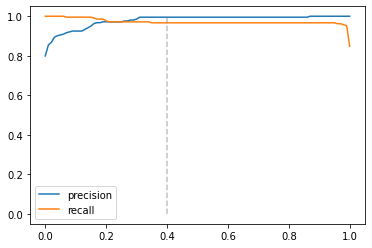

In [108]:
df_scores['p'] = df_scores.tp / (df_scores.tp + df_scores.fp)
df_scores['r'] = df_scores.tp / (df_scores.tp + df_scores.fn)
plt.plot(df_scores.threshold, df_scores.p, label='precision')
plt.plot(df_scores.threshold, df_scores.r, label='recall')

plt.vlines(0.4, 0, 1, color='grey', linestyle='--', alpha=0.5)

plt.legend()
plt.show()

0.3

In [109]:
df_scores['f1'] = 2 * df_scores.p * df_scores.r / (df_scores.p + df_scores.r)

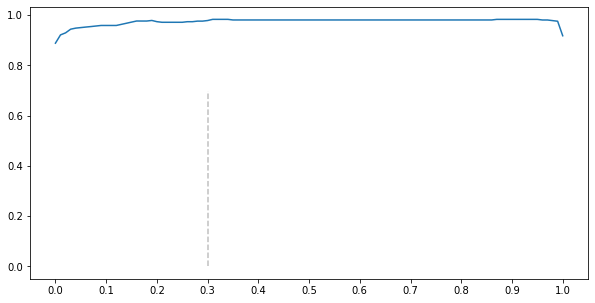

In [110]:
plt.figure(figsize=(10, 5))

plt.plot(df_scores.threshold, df_scores.f1)
plt.vlines(0.3, 0, 0.7, color='grey', linestyle='--', alpha=0.5)

plt.xticks(np.linspace(0, 1, 11))
plt.show()

0.4

Object `maximal` not found.


0.7